In [1]:
import itertools

import numpy as np
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()

import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupKFold, GridSearchCV, RandomizedSearchCV, GroupShuffleSplit
import sklearn.neural_network
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from statannotations.Annotator import Annotator

from gensim.models import Word2Vec

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

In [3]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/griesemer/'

# Load data

In [17]:
mpra_df = pd.read_csv(data_dir + 'mpra_df.tsv', sep='\t') #sequence info

In [18]:
mlm_embeddings = np.load(data_dir + "embeddings/seq_len_5000/embeddings.npy") #masked language model embeddings

In [36]:
mpra_df.head()

,oligo_id,seq,min_free_energy,mpra_variant_id,ref_allele,alt_allele,gene_symbols,chrom,oligo_starts,oligo_ends,...,lfcSE_Ref_SKNSH,pvalue_Ref_SKNSH,padj_Ref_SKNSH,log2FoldChange_Alt_SKNSH,lfcSE_Alt_SKNSH,pvalue_Alt_SKNSH,padj_Alt_SKNSH,stop_codon_dist,group,Expression
6,11_120356470_G_alt,GTGGCTCTTATGTGCCCAGGTGGTGTGGTCAGAGAGTGGATGGGCT...,-33.9,11_120356470_G,C,G,ARHGEF12,11,120356420,120356520,...,"0,117082873","0,009557148","0,026791718","0,222661019","0,117645283","0,058404798","0,123769944",683.0,ARHGEF12,0.033228
7,11_120356470_G_ref,GTGGCTCTTATGTGCCCAGGTGGTGTGGTCAGAGAGTGGATGGGCT...,-35.1,11_120356470_G,C,G,ARHGEF12,11,120356420,120356520,...,"0,117082873","0,009557148","0,026791718","0,222661019","0,117645283","0,058404798","0,123769944",683.0,ARHGEF12,0.145253
8,11_120356473_T_alt,GCTCTTATGTGCCCAGGTGGTGTGGTCAGAGAGTGGATGGGCTTCC...,-31.9,11_120356473_T,G,T,ARHGEF12,11,120356423,120356523,...,"0,102805671","0,052414865","0,11308122","0,214577772","0,103220647","0,037633339","0,085874631",686.0,ARHGEF12,0.263987
9,11_120356473_T_ref,GCTCTTATGTGCCCAGGTGGTGTGGTCAGAGAGTGGATGGGCTTCC...,-31.9,11_120356473_T,G,T,ARHGEF12,11,120356423,120356523,...,"0,102805671","0,052414865","0,11308122","0,214577772","0,103220647","0,037633339","0,085874631",686.0,ARHGEF12,0.303280
10,11_120356584_A_alt,ACATACTAAATAGCAGGCACTTGAAAATGGGTGTGTTTTCTTCCAT...,-22.9,11_120356584_A,G,A,ARHGEF12,11,120356534,120356634,...,"0,273671744","1,82E-10","1,51E-09","-1,590228675","0,273585466","6,15E-09","4,42E-08",797.0,ARHGEF12,-0.931812


In [19]:
cell_type = 'HMEC' #HMEC,HEK293FT,HEPG2,K562,GM12878,SKNSH

In [20]:
# Data Cleaning
# Take only SNP mutations
# Remove nan values in Expression column
# Take only sequences with variants closer than 5000bp to the stop codon (mpra_df.stop_codon_dist<5000)

is_snp = mpra_df.ref_allele.str.len() == mpra_df.alt_allele.str.len()

flt = mpra_df[f'log2FoldChange_Skew_{cell_type}'].isna()  | (~is_snp) | (mpra_df.stop_codon_dist>5000) 

mpra_df = mpra_df[~flt]

In [22]:
mpra_df['Expression'] = mpra_df.apply(lambda x: x[f'log2FoldChange_Alt_{cell_type}'] if x.oligo_id.endswith('_alt') else x[f'log2FoldChange_Ref_{cell_type}'], axis=1)   

In [23]:
# Conver Expression column to float
mpra_df.Expression = mpra_df.Expression.apply(lambda x:x.replace(',','.') if type(x)==str else x).astype(float)

In [24]:
def pearson_r(x,y):
    '''
    Compute Pearson r coefficient between samples x and y
    '''
    x = np.array(x)
    y = np.array(y)
    cov_xy = np.mean((x - x.mean()) * (y - y.mean()))
    r = cov_xy / (x.std() * y.std())
    return r

def pearson_r2_scorer(estimator, X, y):
    '''
    Scikit-learn compatible pearson scorer
    '''
    y_pred = estimator.predict(X).reshape(-1)
    #return scipy.stats.pearsonr(y, y_pred)[0] ** 2
    return pearson_r(y, y_pred)**2

In [25]:
def minseq_model(mpra_df):
    
    '''
    Minimal sequence model from Griesemer et al. 2021
    
    Extracts following features from mpra_df:
    --nucleotide counts for each base (+4) and maximum among them (+1)
    --dinucleotide counts (+16) and maximum among them (+1)
    --maximum homopolymer length for all bases (+4)
    --maximum dinucleotide repeat length length for all bases (+16)
    --sequence uniformity (+1)
    --Minimal free energy (from RNA fold Software) (+1)
    
    Returns:
    Feature matrix X
    '''
    
    kmerizer1 = Kmerizer(k=1)

    nucl_counts = np.stack(mpra_df.seq.apply(lambda seq: kmerizer1.kmerize(seq)))
    max_nucl_counts_all = nucl_counts.max(axis=1)

    kmerizer2 = Kmerizer(k=2)

    dinucl_counts = np.stack(mpra_df.seq.apply(lambda seq: kmerizer2.kmerize(seq)))
    max_dinucl_counts_all = dinucl_counts.max(axis=1)
    
    max_homopol_len = np.stack(mpra_df.seq.apply(lambda seq: max_repeat_length(seq,1)))
    max_dinucl_len = np.stack(mpra_df.seq.apply(lambda seq: max_repeat_length(seq,2)))

    seq_uniformity = mpra_df.seq.apply(lambda seq: np.sum([seq[i]==seq[i-1] for i in range(1,len(seq))])).values
    min_free_energy = mpra_df['min_free_energy'].values
    
    X = np.hstack((nucl_counts,np.expand_dims(max_nucl_counts_all,axis=1),
           dinucl_counts,np.expand_dims(max_dinucl_counts_all,axis=1),
           max_homopol_len, max_dinucl_len,
           np.expand_dims(seq_uniformity,axis=1),
           np.expand_dims(min_free_energy,axis=1),
           ))
    
    return X

def word2vec_model(mpra_df):
    
    '''
    Word2Vec model
    
    '''
    
    kmerizer_w2v = Kmerizer(k=4)
    w2v_model = Word2Vec(sentences=mpra_df.seq.apply(lambda x: kmerizer_w2v.tokenize(x)), 
                         vector_size=128, window=5, min_count=1, workers=4, sg=1)

    word2vec_emb = mpra_df.seq.apply(
        lambda x: np.mean([w2v_model.wv[x]  for x in kmerizer_w2v.tokenize(x)],axis=0))

    X = np.stack(word2vec_emb,axis=0)
    
    return X

In [26]:
def get_embeddings(mpra_df):
    '''
    Compute embeddings using each model
    
    Returns:
    Dictionary of feature matrices, dependent variable, groups for K-fold validation
    '''

    X_emb = mlm_embeddings[mpra_df.index] #Masked Language Model, take only embeddings that were not filtered out

    kmerizer4 = Kmerizer(k=4)
    X_4mer = np.stack(mpra_df.seq.apply(lambda x: kmerizer4.kmerize(x))) #4-mer model

    X_minseq = minseq_model(mpra_df) #Griesemer minimal sequence model
    
    X_w2v = word2vec_model(mpra_df) #Word2Vec model
    
    min_free_energy = mpra_df['min_free_energy'].values
    
    #Only Griesemer model uses RNAfold minimal free energy ba default
    #we add this feature to the other models to provide fair comparison
    
    X_emb = np.hstack((X_emb,np.expand_dims(min_free_energy,axis=1)))
    X_4mer = np.hstack((X_4mer,np.expand_dims(min_free_energy,axis=1)))
    X_w2v = np.hstack((X_w2v,np.expand_dims(min_free_energy,axis=1)))

    data_matrices = {"MLM":X_emb,
                 "4-mer counts":X_4mer,
                 "Word2Vec": X_w2v,
                 "Griesemer et al.": X_minseq,
                }
    
    y = mpra_df['Expression'].values

    groups = mpra_df['group'].values
    
    return data_matrices, y, groups

In [30]:
data_matrices, y, groups = get_embeddings(mpra_df)

In [49]:
def group_cv(clf, parameter_grid, strategy='grid', n_splits = 10, random_state = 1):
    
    '''
    Group Cross-Validation
    If parameter_grid!=None, Use Hyperparameters found in the 0th fold
    
    Parameters:
    clf: Scikit-learn-compatible classifier
    parameter grid: dictionary of parameter values for hyperparameter search
    strategy: 'grid' for Grid Search or 'random' for Random Search
    
    Returns:
    Pearson r^2 coefficient for all folds
    '''

    group_kfold = GroupKFold(n_splits=n_splits)

    kfold_scores = []

    for fold_idx, (train_idx, test_idx) in enumerate(group_kfold.split(X, y, groups)):
        
        #print(f'FOLD {fold_idx}')
        
        X_train, y_train, groups_train = X[train_idx,:], y[train_idx], groups[train_idx]
        X_test, y_test = X[test_idx,:], y[test_idx]

        if fold_idx==0 and parameter_grid!=None:
            print('Performing hyperparameter search in FOLD 0')
            if strategy=='grid':
                gs = make_pipeline(StandardScaler(),
                                            GridSearchCV(clf, parameter_grid, cv=3, verbose=4))
                gs.fit(X_train, y_train, gridsearchcv__groups=groups_train)
                best_params = gs['gridsearchcv'].best_params_
            else:
                rs = make_pipeline(StandardScaler(),
                                            RandomizedSearchCV(clf, parameter_grid, cv=3, random_state=random_state))
                rs.fit(X_train, y_train, randomizedsearchcv__groups=groups_train)
                best_params = rs['randomizedsearchcv'].best_params_  
            print(f'Found best parameters: {best_params}')
        
        if parameter_grid!=None:
            clf.set_params(**best_params) #set parameters from the 0th fold
        
        #train 
        pipe = make_pipeline(StandardScaler(), clf)
        pipe.fit(X_train, y_train)
        
        #inference
        y_pred = pipe.predict(X_test)
        fold_score = pearson_r(y_pred,y_test)**2
        
        kfold_scores.append(fold_score)
        
    return kfold_scores

In [53]:
metrics_mpra = []

clf = sklearn.linear_model.Ridge()
parameter_grid = {'alpha':10.**np.arange(-10,10)}
              
clf = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(64,32,16,), alpha=2, batch_size=1000, learning_rate='constant', 
                 learning_rate_init=5e-4, max_iter=500, shuffle=False, random_state=None)
parameter_grid = None


clf = sklearn.svm.SVR(C=4, epsilon=0.1)
parameter_grid = None#{'C':2.**np.arange(-5,5),'epsilon':10.**np.arange(-5,1)}

for model, X in data_matrices.items():
    
    print(model)
  
    r2 = group_cv(clf,parameter_grid,strategy='grid')
    
    for r2_val in r2:
        metrics_mpra.append((model, r2_val))

metrics_mpra = pd.DataFrame(metrics_mpra, columns=['model','score'])

MLM
4-mer counts
Word2Vec


KeyboardInterrupt: 

In [54]:
X = data_matrices['MLM']

In [274]:
pipe = make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=3)) #limit runtime
#rmse = -cross_val_score(pipe,X,y,scoring="neg_root_mean_squared_error",cv=sklearn.model_selection.GroupKFold(n_splits=10), groups=groups)#.mean()
r2 = cross_val_score(pipe,X,y,scoring=pearson_r2,cv=sklearn.model_selection.GroupKFold(n_splits=10), groups=groups, n_jobs=-1)#.mean()


NameError: name 'cross_val_score' is not defined

In [38]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=2)
train_index, test_index = next(iter(gss.split(X, y, groups)))
X_train, X_test, y_train, y_test = X[train_index,:],X[test_index,:],y[train_index],y[test_index]

In [291]:
M = MLPRegressor(hidden_layer_sizes=(64,32,16,), alpha=2, batch_size=1000, learning_rate='constant', 
                 learning_rate_init=5e-4, max_iter=500, shuffle=False, random_state=None)

In [45]:
M = sklearn.svm.SVR()

In [46]:
M.fit(X_train,y_train)

SVR()

In [47]:
M.score(X_test,y_test)

0.21840541170974137

# Comparing with other embeddings

We also try to predict MPRA expression from alternative embeddings: 4-mer counts and a Word2Vec model.

For this, we need to define some utility functions.

In [28]:
class Kmerizer:
    '''
    Helper class to generate k-mers and Word2Vec embeddings
    '''
    
    def __init__(self, k):
        
        self.k = k
        
        #generate all possible k-mers, e.g. 
        self.kmers = {"".join(x):i for i,x in zip(range(4**k), itertools.product("ACGT",repeat=k))} 
        
    def kmerize(self, seq):
        '''
        Count all k-mers in the sequence 
        Returns:
        A list with counts corresponding to each possible k-mer from self.kmers
        e.g. for k=2 and seq='ACTAC'
        > [0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
        '''
        counts = [0]*4**self.k
        for i in range(len(seq) - self.k + 1): 
            kmer = seq[i:i+self.k]
            counts[self.kmers[kmer]] += 1
        return counts
    
    def tokenize(self, seq):
        '''
        Get all k-mers in the sequence
        Returns:
        A list of all k-mers
        e.g. for 2-mers and seq='ACTAC' 
        > ['AC', 'CT', 'TA', 'AC']
        '''
        kmers = []
        for i in range(len(seq) - self.k + 1): 
            kmer = seq[i:i+self.k]
            kmers.append(kmer)
        return kmers

In [29]:
def max_repeat_length(seq,k):
    
    '''
    Get repeat lengths of all k-mers in sequence
    Returns:
    Array of maximal repeat lengths for all k-mers
    '''

    max_subseq_length = {"".join(x):0 for x in itertools.product("ACGT",repeat=k)}

    for start in range(k):
        n_repeats=1 #each subsequence has at least 1 repeat
        for seq_idx in range(start,len(seq)-k+1,k):
            subseq = seq[seq_idx:seq_idx+k] #current subsequence
            if subseq==seq[seq_idx+k:seq_idx+2*k]: #if repeated at the next position
                n_repeats+=1 #increase repeats counter
            else:
                max_subseq_length[subseq] = max(max_subseq_length[subseq],n_repeats) #is the current subseq repeat longer?
                n_repeats = 1 #reinitialize repeats counter
                
        max_subseq_length[subseq] = max(max_subseq_length[subseq],n_repeats) #end of the sequence
       
    repeat_length = np.array(list(max_subseq_length.values()))
    
    return repeat_length

# Assessing model stability

For a stable model, the predictions are robust with respect to small changes in the train set.

To assess model stability, one performs repeated Cross-Validation: at each round the dataset is split into the same number of folds, but the fold contents is different each time. Then deviations in predictions for each test point are estimated.

Example for classification:

![Model stability](https://i.stack.imgur.com/vqyGM.png)

In [ ]:
#pipe = make_pipeline(sklearn.preprocessing.StandardScaler(), 
#                     sklearn.svm.SVR(C=4, epsilon=0.1))


pipe = make_pipeline(sklearn.preprocessing.StandardScaler(), 
                     sklearn.linear_model.RidgeCV(cv=3)) 

N_rounds = 100 #number of CV rounds
N_splits = 10 #number of CV splits in each round

N_instances = len(y) #total number of test points equals to dataset size

cv_res = np.zeros((N_rounds*N_splits,N_instances)) #CV predictions for each point
cv_res[:] = np.NaN 

cv_scores = [] #Pearson R^2 for each fold in each round, N_rounds X N_splits

for round_idx in range(N_rounds):
    
    print(f'CV round {round_idx}')

    gss = GroupShuffleSplit(n_splits=N_splits, train_size=.9, random_state = round_idx) #10-fold CV

    for fold_idx, (train_idx, test_idx) in enumerate(gss.split(X, y, groups)):
       
        X_train, X_test, y_train, y_test = X[train_idx,:],X[test_idx,:],y[train_idx],y[test_idx]
        
        pipe.fit(X_train,y_train)
        
        y_pred = pipe.predict(X_test)
            
        cv_res[round_idx*N_splits+fold_idx,test_idx] = y_pred #predictions for test instances in this fold in this round
        
        cv_scores.append((pearson_r(y_pred,y_test)**2, round_idx)) #score for this fold in this round
        
cv_scores = pd.DataFrame(cv_scores, columns=['Pearson r^2', 'CV round'])

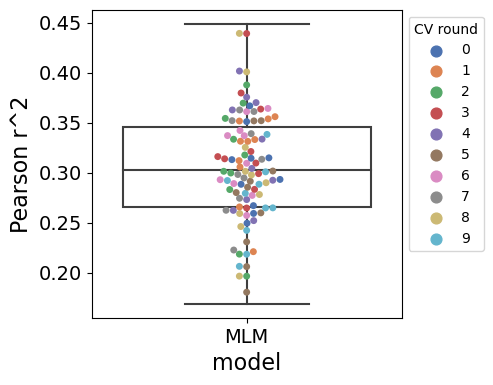

In [57]:
fig, ax = plt.subplots(figsize=(4,4))

cv_scores['model'] = 'MLM'

ax = sns.swarmplot(data=cv_scores[cv_scores['CV round']<10],y='Pearson r^2',x='model',hue="CV round", palette="deep")
ax = sns.boxplot(data=cv_scores,y='Pearson r^2',x='model', boxprops={'facecolor':'None'})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [58]:
y_pred_av = np.nanmean(cv_res,axis=0) #average prediction for each point (not necessarily correct)

mae = np.nanmean(np.absolute(cv_res - y_pred_av)) #mean absolute error for each point across rounds

mae_relative = np.absolute(mae/y_pred_av) #relative MAE w.r.t. average prediction

In [59]:
for pct in (25, 50, 75, 90):
    percentile = np.percentile(mae_relative, pct)
    print(f'{pct}% of points deviate by less than {round(percentile*100):2d}% due to train set change')

25% of points deviate by less than  9% due to train set change
50% of points deviate by less than 15% due to train set change
75% of points deviate by less than 33% due to train set change
90% of points deviate by less than 84% due to train set change


When choosing models, we prefer stable ones.

How to fight instability?

- add regularization
- use stable algorithms
- perform feature engineering

How to estimate generalization performance of an unstable model?

In [60]:
score_per_round = cv_scores.groupby('CV round')['Pearson r^2'].mean()

CV_rounds = np.arange(1,N_rounds+1)

average_score = np.cumsum(score_per_round)/CV_rounds

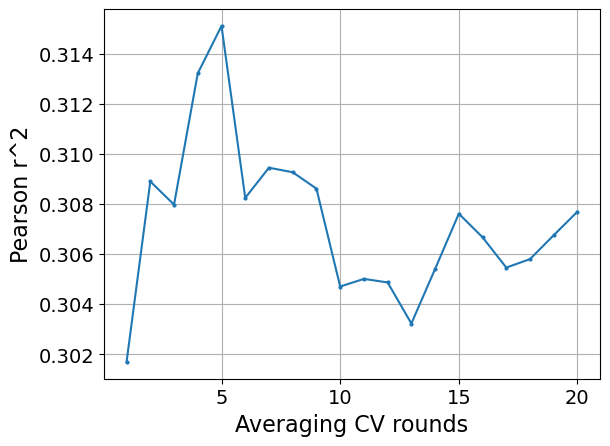

In [61]:
fig, ax = plt.subplots()

ax.plot(CV_rounds, average_score, marker='o', markersize=2)
ax.set_xlabel('Averaging CV rounds')
ax.set_ylabel('Pearson r^2')
ax.grid()

To get estimate generalization performance of an unstable model, one performs repeated K-fold CV. The score is then averaged over all folds and in rounds. The number of repeats can be determined by plotting the averaged performance score vs the number of rounds.

In [73]:
M = MLPRegressor(p_dropout=0.1,weight_decay=2)
M.fit(X_train,y_train,X_test,y_test)


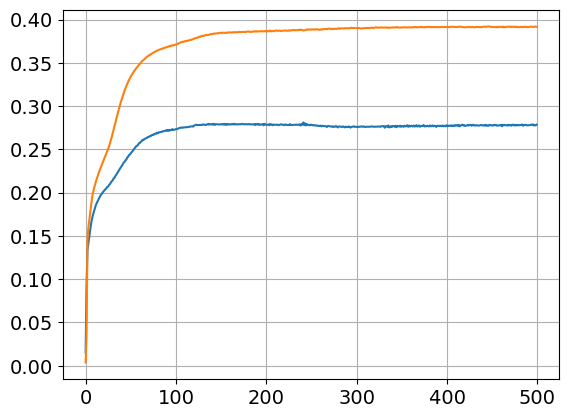

In [74]:
t,v = zip(*M.history)
fig, ax = plt.subplots()
ax.plot(v)
ax.plot(t)
ax.grid()

In [75]:
metrics_mpra = []

clf = sklearn.linear_model.Ridge()
parameter_grid = {'alpha':10.**np.arange(-10,10)}
        
#clf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000,n_jobs=-1,min_samples_leaf=25)
#parameter_grid = None

        
clf = MLPRegressor(p_dropout=0.1,weight_decay=2)
parameter_grid = None


for model, X in data_matrices.items():
    
    print(model)
  
    r2 = group_cv(clf,parameter_grid,strategy='grid')
    
    for r2_val in r2:
        metrics_mpra.append((model, r2_val))

metrics_mpra = pd.DataFrame(metrics_mpra, columns=['model','score'])

MLM


/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga

4-mer counts


/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga

Word2Vec


/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga

Griesemer et al.


/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga

In [33]:
metrics_mpra.groupby('model').mean()

,score
model,
4-mer counts,0.158002
Griesemer et al.,0.185053
MLM,0.269795
Word2Vec,0.179525


In [34]:
mpl.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 
                     'axes.titlesize':14, 'axes.labelsize':16})

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MLM vs. 4-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
MLM vs. Word2Vec: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
MLM vs. Griesemer et al.: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:5.859e-03 Stat=2.000e+00


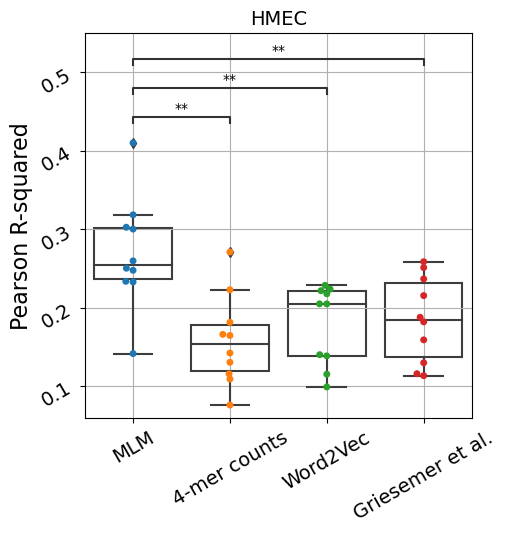

In [35]:
box_pairs=[
    ("MLM", "4-mer counts"),
    ("MLM", "Word2Vec"),
    ("MLM", "Griesemer et al."),
    ]

fig, ax = plt.subplots(figsize=(5,5), dpi=100)

ax = sns.swarmplot(data=metrics_mpra, x="model", y="score") #scatter plot
ax = sns.boxplot(data=metrics_mpra, x="model", y="score", boxprops={'facecolor':'None'})

annotator = Annotator(ax, box_pairs, data=metrics_mpra, x="model", y="score")
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
#annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="BH")

annotator.apply_and_annotate()

ax.set_xlabel("")
ax.set_ylabel("Pearson R-squared")
ax.tick_params(rotation=30)
ax.set_title(cell_type)
ax.grid()

#fig.savefig("../../../../Plots/Downstream_mpra.svg") 